# Basic FISSA usage

This notebook contains a step-by-step example of how to use the functional interface to the [FISSA](https://github.com/rochefort-lab/fissa) toolbox.

For more details about the methodology behind FISSA, please see our paper:
> S. W. Keemink, S. C. Lowe, J. M. P. Pakan, E. Dylda, M. C. W. van Rossum, and N. L. Rochefort. FISSA: A neuropil decontamination toolbox for calcium imaging signals, *Scientific Reports*, **8**(1):3493, 2018. doi: [10.1038/s41598-018-21640-2](https://www.doi.org/10.1038/s41598-018-21640-2).

See [basic_usage_func.py](https://github.com/rochefort-lab/fissa/blob/master/examples/basic_usage_func.py) (or [basic_usage_func_windows.py](https://github.com/rochefort-lab/fissa/blob/master/examples/basic_usage_func_windows.py) for Windows users) for a short example script outside of a notebook interface.

### Import packages

In [1]:
# Import the FISSA toolbox
import fissa

In [2]:
# For plotting our results, import numpy and matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Fetch the colormap object for Cynthia Brewer's Paired color scheme
cmap = plt.get_cmap("Paired")

## Running FISSA

With the functional interface to FISSA, everything is handled in a single function call to ``fissa.run_fissa``, which returns the decontaminated signals.

The mandatory inputs to `fissa.run_fissa` are:
- the experiment images
- the regions of interest (ROIs) to extract

Images can be given as a path to a folder containing tiff stacks:
```python
images = "folder"
```
Each of these tiff stacks in the folder (e.g. `"folder/trial_001.tif"`) is a trial with many frames.

Alternatively, the image data can be given as a list of paths to tiffs:
```python
images = ["folder/trial_001.tif", "folder/trial_002.tif", "folder/trial_003.tif"]
```
or as a list of arrays which you have already loaded into memory:
```python
images = [array1, array2, array3, ...]
```

For the ROIs input, you can either provide a single set of ROIs, or a set of ROIs for every image.

If the ROIs were defined using ImageJ, use ImageJ's export function to save them in a zip.
Then, provide the ROI filename,
```python
rois = "rois.zip"  # for a single set of rois across images
rois = ["rois1.zip", "rois2.zip", ...]  # for a roiset for each image
```
or list of ROI filenames
```python
rois = ["rois1.zip", "rois2.zip", ...]  # for a roiset for each image
```
Defining a different roiset per image can be useful if you need to adjust for motion drift, for example.

Then, we can run FISSA as follows.

In [4]:
# Define image and ROI locations
images_location = "exampleData/20150529"
rois_location = "exampleData/20150429.zip"

# Call FISSA using the functional interface
result = fissa.run_fissa(images_location, rois_location)

Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 4 ROIs across 3 trials in 0.654 seconds.


Separating data:   0%|          | 0/4 [00:00<?, ?it/s]

Finished separating signals from 4 ROIs across 3 trials in 1.181 seconds


Note that although the functional interface is very straight forward, you can only access the result which is returned by the function.

If you need to access the raw traces, ROI masks, or demixing matrix, you need to use the more flexible [object-oriented (class based) interface](https://rochefort-lab.github.io/fissa/examples/Basic%20usage.html), with [fissa.Experiment](https://fissa.readthedocs.io/en/stable/source/packages/fissa.core.html#fissa.core.Experiment), instead.

## Working with results

The output of `fissa.run_fissa()` is structured as a 2-d array of 2-d arrays (it can't be a 4-d array because of differing trial lengths).

The results from the cell (roi) numbered `c` and the trial (TIFF) numbered `t` are located at `result[c, t][0, :]`.

The fourth (last) dimension works through frames within the TIFF file.

The third dimension contains all the decontaminated signals from the ROI and its surrounding neuropil.
The 0-th entry of this is the signal which most closely corresponds to the raw signal within the ROI.
The other signals are the (isolated) contaminants.

Let's plot all the ROI signals for a given trial in a single plot:

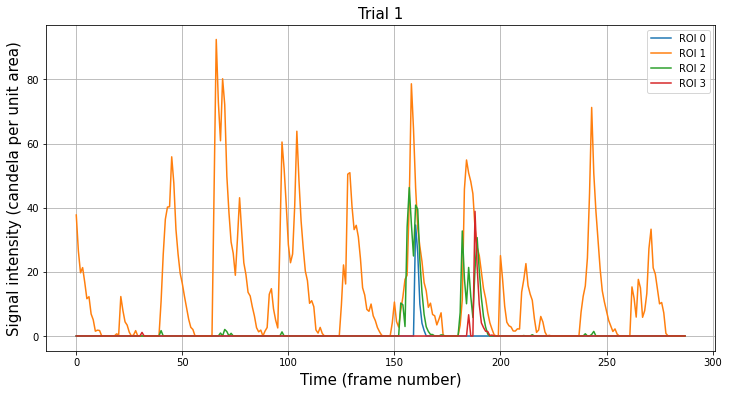

In [5]:
n_roi = result.shape[0]
n_trial = result.shape[1]

trial = 1

plt.figure(figsize=(12, 6))

for i_roi in range(n_roi):
    plt.plot(result[i_roi, trial][0, :], label="ROI {}".format(i_roi))

plt.title("Trial {}".format(trial), fontsize=15)
plt.xlabel("Time (frame number)", fontsize=15)
plt.ylabel("Signal intensity (candela per unit area)", fontsize=15)
plt.grid()
plt.legend()
plt.show()

We next plot the traces across all ROIs and trials:

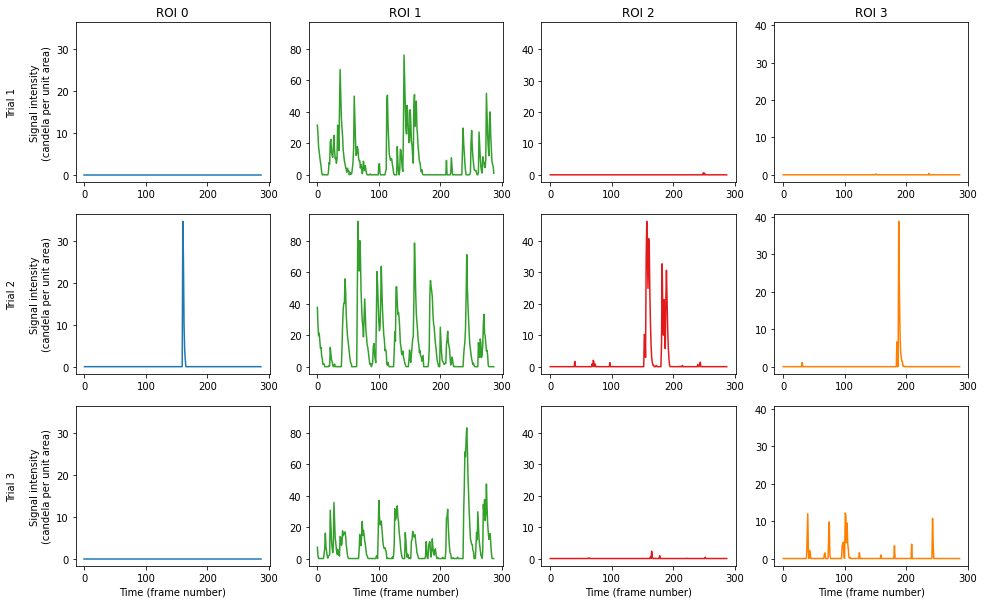

In [6]:
# Get the number of ROIs and trials
n_roi = result.shape[0]
n_trial = result.shape[1]

# Find the maximum signal intensities for each ROI
roi_max = [
    np.max([np.max(result[i_roi, i_trial][0]) for i_trial in range(n_trial)])
    for i_roi in range(n_roi)
]

# Plot our figure using subplot panels
plt.figure(figsize=(16, 10))
for i_roi in range(n_roi):
    for i_trial in range(n_trial):
        # Make subplot axes
        i_subplot = 1 + i_trial * n_roi + i_roi
        plt.subplot(n_trial, n_roi, i_subplot)
        # Plot the data
        plt.plot(
            result[i_roi][i_trial][0, :],
            color=cmap((i_roi * 2 + 1) % cmap.N),
        )
        # Labels and boiler plate
        plt.ylim([-0.05 * roi_max[i_roi], roi_max[i_roi] * 1.05])
        if i_roi == 0:
            plt.ylabel(
                "Trial {}\n\nSignal intensity\n(candela per unit area)".format(
                    i_trial + 1
                )
            )
        if i_trial == 0:
            plt.title("ROI {}".format(i_roi))
        if i_trial == n_trial - 1:
            plt.xlabel("Time (frame number)")

plt.show()

### df/f<sub>0</sub>

The default output from `fissa.run_fissa` is in the same units as the raw input (candelas per unit area).

It is often desired to calculate the intensity of a signal relative to the baseline value, df/f<sub>0</sub>, for the traces.
`fissa.run_fissa` will do this for you provide the argument `return_deltaf=True`, and the sampling frequency of your TIFF files with `freq=sample_frequency`.
The sampling frequency must be provided because the data is smoothed in order to determine the baseline value f<sub>0</sub>.

When `return_deltaf=True`, `run_fissa` will return the df/f<sub>0</sub> output *instead* of the source signal traces scaled at the recording intensity.
If you need to access both the standard FISSA output *and* the df/f<sub>0</sub> output at the same time, you should use the more flexible [fissa.Experiment](https://fissa.readthedocs.io/en/stable/source/packages/fissa.core.html#fissa.core.Experiment) FISSA interface instead, as described in [this example](https://rochefort-lab.github.io/fissa/examples/Basic%20usage.html).

In [7]:
sample_frequency = 10  # Hz

deltaf = fissa.run_fissa(
    images_location, rois_location, freq=sample_frequency, return_deltaf=True
)

Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 4 ROIs across 3 trials in 0.627 seconds.


Separating data:   0%|          | 0/4 [00:00<?, ?it/s]

Finished separating signals from 4 ROIs across 3 trials in 1.152 seconds


Calculating Δf/f0:   0%|          | 0/4 [00:00<?, ?it/s]

Finished calculating Δf/f0 for raw and result signals in 0.038 seconds


Note that by default, f<sub>0</sub> is determined as the minimum across all trials (all tiffs) to ensure that results are directly comparable between trials, but you can normalise each trial individually instead if you prefer by setting `deltaf_across_trials=False`.

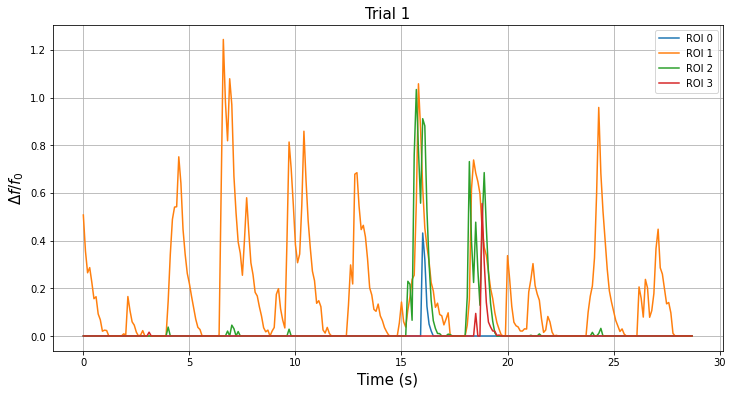

In [8]:
n_roi = deltaf.shape[0]
n_trial = deltaf.shape[1]

trial = 1

n_frames = deltaf[0, trial].shape[1]

plt.figure(figsize=(12, 6))
for i_roi in range(n_roi):
    plt.plot(
        np.arange(0, n_frames, dtype=np.float64) / sample_frequency,
        deltaf[i_roi, trial][0, :],
        label="ROI {}".format(i_roi),
    )

plt.title("Trial {}".format(trial), fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
plt.ylabel("$\Delta f/f_0$", fontsize=15)
plt.grid()
plt.legend()
plt.show()

Since FISSA is very good at removing contamination from the ROI signals, the minimum value on the decontaminated trace will typically be `0.`.
Consequently, we use the minimum value of the (smoothed) raw signal to provide the f<sub>0</sub> from the raw trace for both the raw and decontaminated df/f<sub>0</sub>.

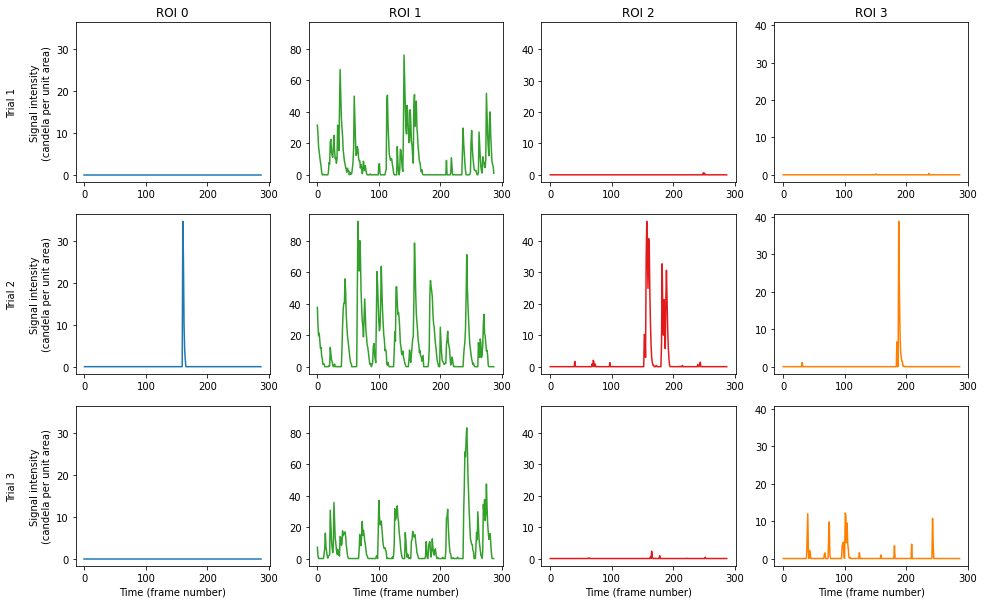

In [9]:
# Get the number of ROIs and trials
n_roi = result.shape[0]
n_trial = result.shape[1]

# Find the maximum signal intensities for each ROI
roi_max = [
    np.max([np.max(result[i_roi, i_trial][0]) for i_trial in range(n_trial)])
    for i_roi in range(n_roi)
]

# Plot our figure using subplot panels
plt.figure(figsize=(16, 10))
for i_roi in range(n_roi):
    for i_trial in range(n_trial):
        # Make subplot axes
        i_subplot = 1 + i_trial * n_roi + i_roi
        plt.subplot(n_trial, n_roi, i_subplot)
        # Plot the data
        plt.plot(
            result[i_roi][i_trial][0, :],
            color=cmap((i_roi * 2 + 1) % cmap.N),
        )
        # Labels and boiler plate
        plt.ylim([-0.05 * roi_max[i_roi], roi_max[i_roi] * 1.05])
        if i_roi == 0:
            plt.ylabel(
                "Trial {}\n\nSignal intensity\n(candela per unit area)".format(
                    i_trial + 1
                )
            )
        if i_trial == 0:
            plt.title("ROI {}".format(i_roi))
        if i_trial == n_trial - 1:
            plt.xlabel("Time (frame number)")

plt.show()

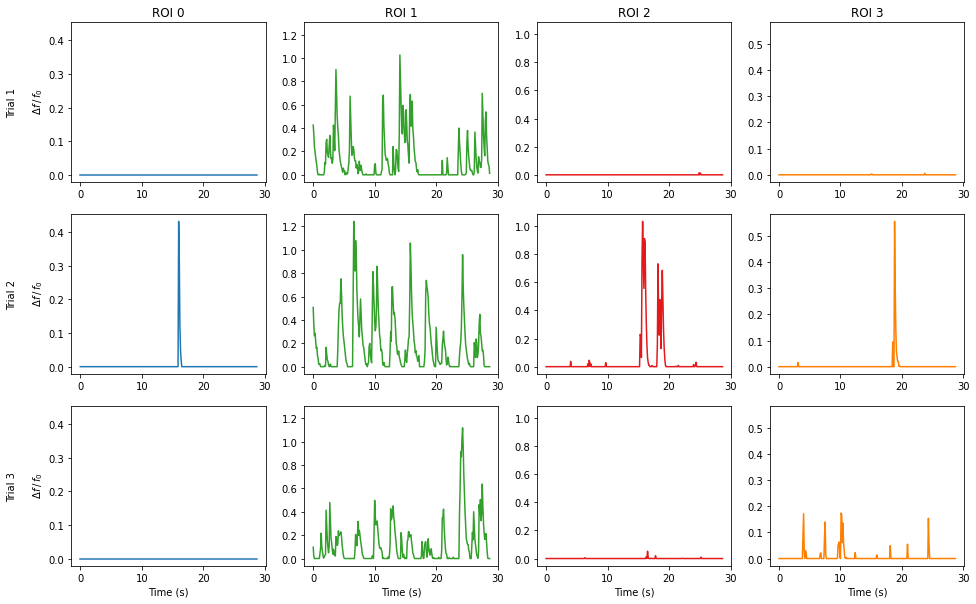

In [10]:
# Get the number of ROIs and trials
n_roi = deltaf.shape[0]
n_trial = deltaf.shape[1]

# Find the maximum df/f0 for each ROI
roi_max = [
    np.max([np.max(deltaf[i_roi, i_trial][0]) for i_trial in range(n_trial)])
    for i_roi in range(n_roi)
]

# Plot our figure using subplot panels
plt.figure(figsize=(16, 10))
for i_roi in range(n_roi):
    for i_trial in range(n_trial):
        # Make subplot axes
        i_subplot = 1 + i_trial * n_roi + i_roi
        plt.subplot(n_trial, n_roi, i_subplot)
        # Plot the data
        n_frames = deltaf[i_roi, i_trial].shape[1]
        plt.plot(
            np.arange(0, n_frames, dtype=np.float64) / sample_frequency,
            deltaf[i_roi][i_trial][0, :],
            color=cmap((i_roi * 2 + 1) % cmap.N),
        )
        # Labels and boiler plate
        plt.ylim([-0.05 * roi_max[i_roi], roi_max[i_roi] * 1.05])
        if i_roi == 0:
            plt.ylabel(
                "Trial {}\n\n $\Delta f\,/\,f_0$".format(i_trial + 1),
            )
        if i_trial == 0:
            plt.title("ROI {}".format(i_roi))
        if i_trial == n_trial - 1:
            plt.xlabel("Time (s)")

plt.show()

## Caching

You can optionally provide FISSA with the name of a cache directory.
If this argument is given, FISSA will load any output that is present from there instead of recomputing it.
If the cache directory is empty, FISSA will save its outputs there.

In [11]:
# Define the folder where FISSA's outputs will be cached, so they can be
# quickly reloaded in the future without having to recompute them.
#
# This argument is optional; if it is not provided, FISSA will not save its
# results for later use.
#
# If the output directory already exists, FISSA will load the contents of
# the cache instead of recomputing it.
#
# Note: you *must* use a different folder for each experiment, otherwise
# FISSA will load the existing data instead of computing results for the
# new experiment.
#
# In this example, we will use the current datetime as the  name of the
# experiment, but you can name your experiments however you want to.

import datetime

output_folder = "fissa-example_{}".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
)

print(output_folder)

fissa-example_2021-07-15_01-01-54


In [12]:
# Run FISSA, saving to the output directory
result = fissa.run_fissa(images_location, rois_location, output_folder)

Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 4 ROIs across 3 trials in 0.624 seconds.
Saving extracted traces to fissa-example_2021-07-15_01-01-54/prepared.npz


Separating data:   0%|          | 0/4 [00:00<?, ?it/s]

Finished separating signals from 4 ROIs across 3 trials in 1.310 seconds
Saving results to fissa-example_2021-07-15_01-01-54/separated.npz


### Exporting to MATLAB

The results can easily be exported to a MATLAB-compatible matfile as follows.

We can either use `export_to_matlab=True`, which will include export to matlab with the default filename, `'separated.mat'`, within the cache directory (the cache directory being set by our `output_folder` variable).

In [13]:
result = fissa.run_fissa(
    images_location, rois_location, output_folder, export_to_matlab=True
)

Reloading data from cache fissa-example_2021-07-15_01-01-54/prepared.npz
Reloading data from cache fissa-example_2021-07-15_01-01-54/separated.npz
Reloading data from cache fissa-example_2021-07-15_01-01-54/separated.npz


Alternatively, we can manually specify the path to the output directory.

In this case, setting a cache directory is optional.

In [14]:
result = fissa.run_fissa(
    images_location, rois_location, export_to_matlab="experiment_results.mat"
)

Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 4 ROIs across 3 trials in 0.624 seconds.


Separating data:   0%|          | 0/4 [00:00<?, ?it/s]

Finished separating signals from 4 ROIs across 3 trials in 1.250 seconds


Loading the generated file, `output_folder/separated.mat` or your custom filename, in MATLAB will provide you with all of FISSA's outputs.

These interface similarly as `experiment.raw`, and `experiment.result` described above, with a few small differences.

With the python interface, the outputs are 2d numpy.ndarrays each element of which is itself a 2d numpy.ndarrays.
In comparison, when the output is loaded into MATLAB this becomes a 2d cell-array each element of which is a 2d matrix.

Additionally, whilst Python indexes from 0, MATLAB indexes from 1 instead.
As a consequence of this, the results seen on Python for a given roi and trial `experiment.result[roi, trial]` correspond to the index `S.result{roi + 1, trial + 1}` on MATLAB.

Our first plot in this notebook can be replicated in MATLAB as follows:
```octave
% Load the FISSA output data
% S = load('fissa-example/separated.mat')
S = load('experiment_results.mat')
% Select the second trial
% On Python, this is equivalent to trial = 1
trial = 2;
% Plot the result traces for each ROI
figure; hold on;
for i_roi = 1:size(S.result, 1);
    plot(S.result{i_roi, trial}(1, :));
end
xlabel('Time (frame number)');
ylabel('Signal intensity (candela per unit area)');
grid on;
box on;
set(gca,'TickDir','out');
```

## Customisation

### Controlling verbosity

The level of verbosity of FISSA can be controlled with the `verbosity` parameter.

The default is `verbosity=1`.

If the verbosity parameter is higher, FISSA will print out more information while it is processing.
This can be helpful for debugging puproses.
The verbosity reaches its maximum at `verbosity=6`.

If `verbosity=0`, FISSA will run silently.

In [15]:
# Call FISSA with elevated verbosity
result = fissa.run_fissa(images_location, rois_location, verbosity=2)

Doing region growing and data extraction for 3 trials...
  Images:
    exampleData/20150529/AVG_A01.tif
    exampleData/20150529/AVG_A02.tif
    exampleData/20150529/AVG_A03.tif
  ROI sets:
    exampleData/20150429.zip
    exampleData/20150429.zip
    exampleData/20150429.zip
  nRegions: 4
  expansion: 1


Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 4 ROIs across 3 trials in 0.630 seconds.
Doing signal separation for 4 ROIs over 3 trials...
  method: 'nmf'
  alpha: 0.1
  max_iter: 20000
  max_tries: 1
  tol: 0.0001


Separating data:   0%|          | 0/4 [00:00<?, ?it/s]

Finished separating signals from 4 ROIs across 3 trials in 1.253 seconds


### Analysis parameters

FISSA has several user-definable settings, which can be set as optional arguments to `fissa.run_fissa`.

In [16]:
# FISSA uses multiprocessing to speed up its processing.
# By default, it will spawn one worker per CPU core on your machine.
# However, if you have a lot of cores and not much memory, you many not
# be able to suport so many workers simultaneously.
# In particular, this can be problematic during the data preparation step
# in which TIFFs are loaded into memory.
# The default number of cores for the data preparation and separation steps
# can be changed as follows.
ncores_preparation = 4  # If None, uses all available cores
ncores_separation = None  # if None, uses all available cores

# By default, FISSA uses 4 subregions for the neuropil region.
# If you have very dense data with a lot of different signals per unit area,
# you may wish to increase the number of regions.
n_regions = 8

# By default, each surrounding region has the same area as the central ROI.
# i.e. expansion = 1
# However, you may wish to increase or decrease this value.
expansion = 0.75

# The degree of signal sparsity can be controlled with the alpha parameter.
alpha = 0.02

# If you change the experiment parameters, you need to change the cache directory too.
# Otherwise you will reload the results from the previous run instead of computing
# the new results.
output_folder2 = output_folder + "_alt"

# Run FISSA with these parameters
result = fissa.run_fissa(
    images_location,
    rois_location,
    output_folder2,
    nRegions=n_regions,
    expansion=expansion,
    alpha=alpha,
    ncores_preparation=ncores_preparation,
    ncores_separation=ncores_separation,
)

Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 4 ROIs across 3 trials in 0.959 seconds.
Saving extracted traces to fissa-example_2021-07-15_01-01-54_alt/prepared.npz


Separating data:   0%|          | 0/4 [00:00<?, ?it/s]

Finished separating signals from 4 ROIs across 3 trials in 4.06 seconds
Saving results to fissa-example_2021-07-15_01-01-54_alt/separated.npz


We can plot the new results for our example trace from before. Although we doubled the number of neuropil regions around the cell, very little has changed for this example because there were not many sources of contamination.

However, there will be more of a difference if your data has more neuropil sources per unit area within the image.

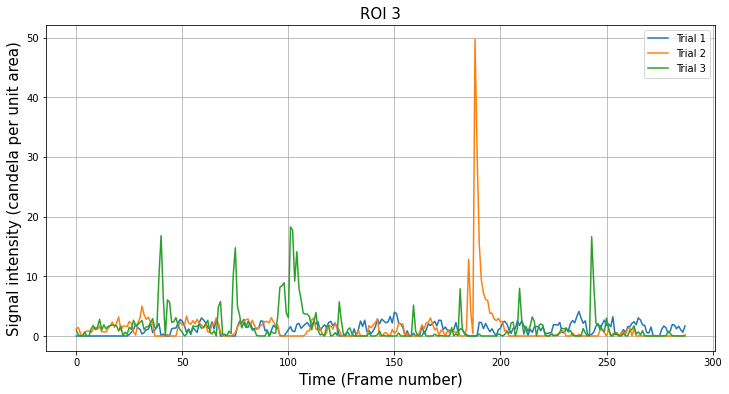

In [17]:
n_roi = result.shape[0]
n_trial = result.shape[1]

i_roi = 3

plt.figure(figsize=(12, 6))

for i_trial in range(n_trial):
    plt.plot(result[i_roi, i_trial][0, :], label="Trial {}".format(i_trial + 1))

plt.title("ROI {}".format(i_roi), fontsize=15)
plt.xlabel("Time (Frame number)", fontsize=15)
plt.ylabel("Signal intensity (candela per unit area)", fontsize=15)
plt.grid()
plt.legend()
plt.show()

## Working with very large tiff files

By default, FISSA loads entire TIFF files into memory at once and then manipulates all ROIs within the TIFF.
This is more efficient, but can be problematic when working with very large TIFF files which are too big to be loaded into memory all at once.

If you have out-of-memory problems, you can try reducing the number of workers during the memory-intensive preparation step.

In [18]:
result = fissa.run_fissa(images_location, rois_location, ncores_preparation=1)

Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 4 ROIs across 3 trials in 0.466 seconds.


Separating data:   0%|          | 0/4 [00:00<?, ?it/s]

Finished separating signals from 4 ROIs across 3 trials in 1.096 seconds


Alternatively, you can activate FISSA's low memory mode.
In this mode, it will load frames one at a time.

In [19]:
result = fissa.run_fissa(images_location, rois_location, lowmemory_mode=True)

Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 4 ROIs across 3 trials in 2.33 seconds.


Separating data:   0%|          | 0/4 [00:00<?, ?it/s]

Finished separating signals from 4 ROIs across 3 trials in 2.86 seconds
